# 🔧 **Configurações iniciais**

In [162]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 📚 **Bibliotecas**

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# 📕 **Leitura do arquivo**

In [98]:
df_sl = pd.read_csv('/content/drive/My Drive/Data/ocorrencias_2021_2024_sl_editado.csv', sep = ",", encoding='utf-8')

# 📊 **Análise descritiva - Crimes contra a mulher em São Leopoldo**

### Edições

In [99]:
# Excluir todas as linhas onde a coluna 'Bairro Classificação' seja igual a 'SEM INFORMACAO' ou 'MORRO DO PAULA'
df_sl = df_sl[~df_sl['Bairro Classificação'].isin(['SEM INFORMACAO', 'MORRO DO PAULA'])]

In [100]:
# Filtrar apenas os crimes contra mulheres, excluindo "Outros" e "Furto/Roubo"
df_filtered = df_sl[(df_sl['Classificação Segurança Mulheres'] != 'Outros') &
                    (df_sl['Classificação Segurança Mulheres'] != 'Furto/Roubo')]

# Contar o total de crimes por bairro
total_crimes_contra_mulher = df_filtered['Bairro Classificação'].value_counts().reset_index()
total_crimes_contra_mulher.columns = ['Bairro Classificação', 'Total de Crimes']

In [101]:
# Normalizar os nomes dos bairros em total_crimes_contra_mulher
total_crimes_contra_mulher['Bairro Classificação'] = (
    total_crimes_contra_mulher['Bairro Classificação']
    .str.lower()
    .str.replace(' ', '-')
)

## **🌎 Mapa de São Leopoldo**

In [102]:
# Importar as bibliotecas necessárias
import os
import folium
import geopandas as gpd
from folium import Choropleth
from folium.features import Choropleth

In [103]:
# Caminho para a pasta com os arquivos GeoJSON
pasta_mapa = '/content/drive/MyDrive/Data/MapaSL'
arquivos_geojson = [f for f in os.listdir(pasta_mapa) if f.endswith('.geojson')]

# Lista para armazenar cada GeoDataFrame temporário
geodados = []

for arquivo in arquivos_geojson:
    caminho = os.path.join(pasta_mapa, arquivo)
    gdf_temp = gpd.read_file(caminho)
    # Extrai o nome do bairro do nome do arquivo
    nome_bairro = os.path.splitext(arquivo)[0]
    gdf_temp['nome_bairro'] = nome_bairro
    geodados.append(gdf_temp)

# Concatena todos os GeoDataFrames em um só
gdf_combined = gpd.GeoDataFrame(pd.concat(geodados, ignore_index=True))

### Mapa - Crimes contra a mulher

In [104]:
# Normalizar os nomes dos bairros
total_crimes_contra_mulher['Bairro Classificação'] = (
    total_crimes_contra_mulher['Bairro Classificação']
    .str.strip()
    .str.title()
)
gdf_combined['nome_bairro'] = gdf_combined['nome_bairro'].str.strip().str.title()

In [105]:
# Mapa base de São Leopoldo
mapa_sl_contra_mulher = folium.Map(location=[-29.7549, -51.1498], zoom_start=12)

# Adicionar o mapa coroplético
Choropleth(
    geo_data=gdf_combined,
    name="Choropleth",
    data=total_crimes_contra_mulher,
    columns=["Bairro Classificação", "Total de Crimes"],
    key_on="feature.properties.nome_bairro",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.9,
    line_color="black",
    legend_name="Total de Crimes contra Mulheres",
    nan_fill_color="white"
).add_to(mapa_sl_contra_mulher)

# Adicionar o nome de cada bairro no centro da área
for _, row in gdf_combined.iterrows():
    # Calcular o centroide de cada bairro
    centroid = row['geometry'].centroid
    nome_bairro = row['nome_bairro'].replace('-', ' ')
    folium.Marker(
        location=[centroid.y, centroid.x],
        icon=folium.DivIcon(html=f"""<div style="font-size: 12px; color: black;">{nome_bairro}</div>""")
    ).add_to(mapa_sl_contra_mulher)

folium.LayerControl().add_to(mapa_sl_contra_mulher)

# Exibir o mapa
mapa_sl_contra_mulher

### Mapa - Crimes contra a mulher (Porcentagem)

In [106]:
# Calcular a porcentagem de crimes contra mulheres para cada bairro
total_crimes_contra_mulher['Porcentagem Crimes Contra Mulher'] = (
    total_crimes_contra_mulher['Total de Crimes'] / total_crimes_contra_mulher['Total de Crimes'].sum() * 100
)

# Mesclar a porcentagem de crimes ao GeoDataFrame
gdf_combined = gdf_combined.merge(total_crimes_contra_mulher, left_on="nome_bairro", right_on="Bairro Classificação", how="left")

# Mapa base de São Leopoldo
mapa_sl_contra_mulher = folium.Map(location=[-29.7549, -51.1498], zoom_start=12)

# Adicionar o mapa coroplético
Choropleth(
    geo_data=gdf_combined,
    name="Choropleth",
    data=total_crimes_contra_mulher,
    columns=["Bairro Classificação", "Total de Crimes"],
    key_on="feature.properties.nome_bairro",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.9,
    line_color="black",
    legend_name="Total de Crimes contra Mulheres",
    nan_fill_color="white"
).add_to(mapa_sl_contra_mulher)

# Adicionar o nome de cada bairro e a porcentagem de crimes no centro da área
for _, row in gdf_combined.iterrows():
    # Calcular o centroide de cada bairro
    centroid = row['geometry'].centroid
    nome_bairro = row['nome_bairro'].replace('-', ' ')
    porcentagem = row['Porcentagem Crimes Contra Mulher'] if pd.notnull(row['Porcentagem Crimes Contra Mulher']) else 0
    folium.Marker(
        location=[centroid.y, centroid.x],
        icon=folium.DivIcon(html=f"""<div style="font-size: 12px; color: black;">
                                     {nome_bairro}<br>{porcentagem:.2f}%</div>""")
    ).add_to(mapa_sl_contra_mulher)

# Adicionar controle de camadas
folium.LayerControl().add_to(mapa_sl_contra_mulher)

# Exibir o mapa
mapa_sl_contra_mulher

## 📉 **Análises**

### **Porcentagem de Crimes Cometidos contra Mulheres por Bairro**

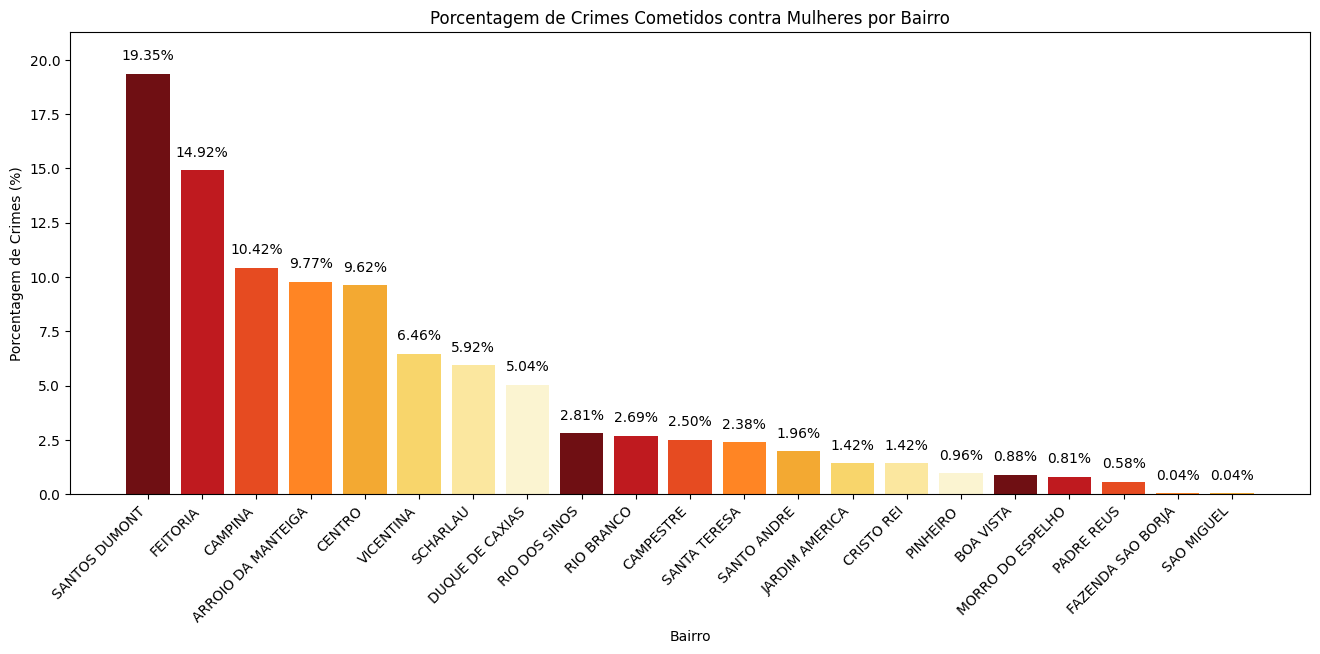

In [158]:
# Filtrando o DataFrame para crimes cometidos contra mulheres
filtered_df = df_sl[~df_sl['Classificação Segurança Mulheres'].isin(['Outros', 'Furto/Roubo'])]

# Calculando a porcentagem de crimes por bairro
crime_percentage = filtered_df['Bairro Classificação'].value_counts(normalize=True) * 100

# Convertendo o resultado para um DataFrame
crime_percentage_df = crime_percentage.reset_index()
crime_percentage_df.columns = ['Bairro', 'Porcentagem de Crimes (%)']

colors = ["#6F0F13", "#BF1A1F", "#E64B21", "#FF8524", "#F3A932", "#F8D56B", "#FBE79F", "#FBF4D1"]

# Criando o gráfico de barras
plt.figure(figsize=(16, 6))
bars = plt.bar(crime_percentage_df['Bairro'], crime_percentage_df['Porcentagem de Crimes (%)'], color=colors[:len(crime_percentage_df)])
plt.xlabel('Bairro')
plt.ylabel('Porcentagem de Crimes (%)')
plt.xticks(rotation=45, ha='right')
plt.title('Porcentagem de Crimes Cometidos contra Mulheres por Bairro')

plt.ylim(0, crime_percentage_df['Porcentagem de Crimes (%)'].max() * 1.1)

# Adicionando as porcentagens acima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}%', ha='center', va='bottom')

plt.show()

### **Total de Ocorrências contra a mulher por Tipo de Enquadramento**

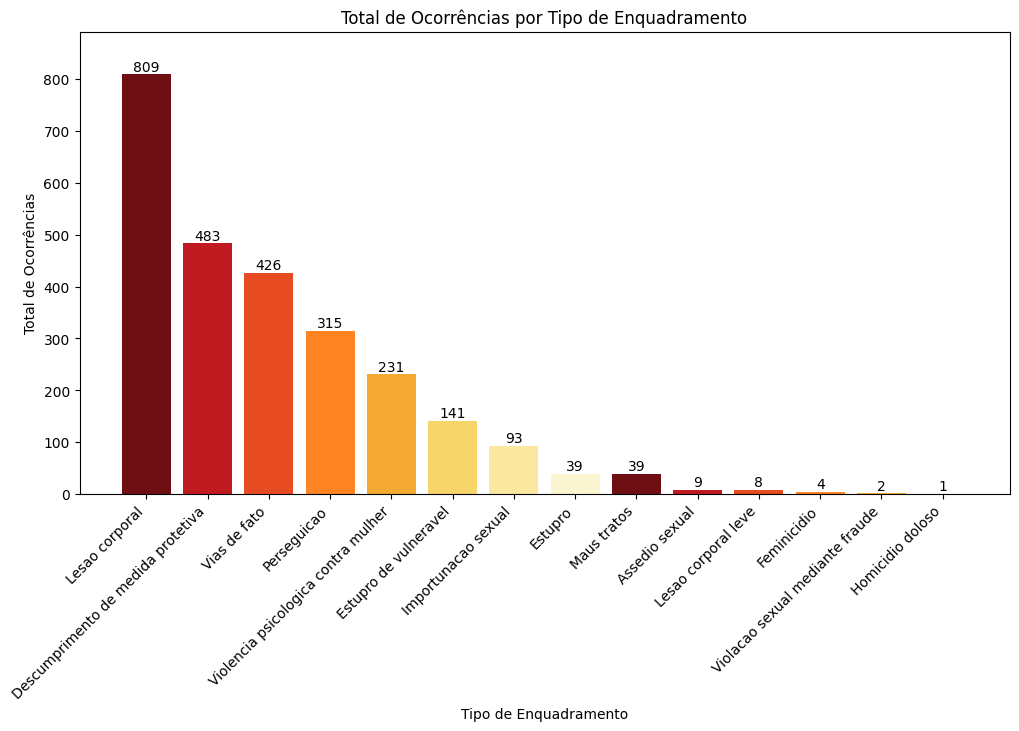

In [157]:
# Filtrando o DataFrame para crimes cometidos contra mulheres
filtered_df = df_sl[~df_sl['Classificação Segurança Mulheres'].isin(['Outros', 'Furto/Roubo'])]

# Calculando o total de ocorrências por tipo de enquadramento
crime_counts = filtered_df['Classificação Segurança Mulheres'].value_counts()

# Convertendo o resultado para um DataFrame
crime_counts_df = crime_counts.reset_index()
crime_counts_df.columns = ['Tipo de Enquadramento', 'Total de Ocorrências']

colors = ["#6F0F13", "#BF1A1F", "#E64B21", "#FF8524", "#F3A932", "#F8D56B", "#FBE79F", "#FBF4D1"]

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))
bars = plt.bar(crime_counts_df['Tipo de Enquadramento'], crime_counts_df['Total de Ocorrências'], color=colors[:len(crime_counts_df)])
plt.xlabel('Tipo de Enquadramento')
plt.ylabel('Total de Ocorrências')
plt.xticks(rotation=45, ha='right')
plt.title('Total de Ocorrências por Tipo de Enquadramento')

plt.ylim(0, crime_counts_df['Total de Ocorrências'].max() * 1.1)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{int(yval)}', ha='center', va='bottom')

plt.show()

### **Total de Ocorrências contra a mulher por Local**

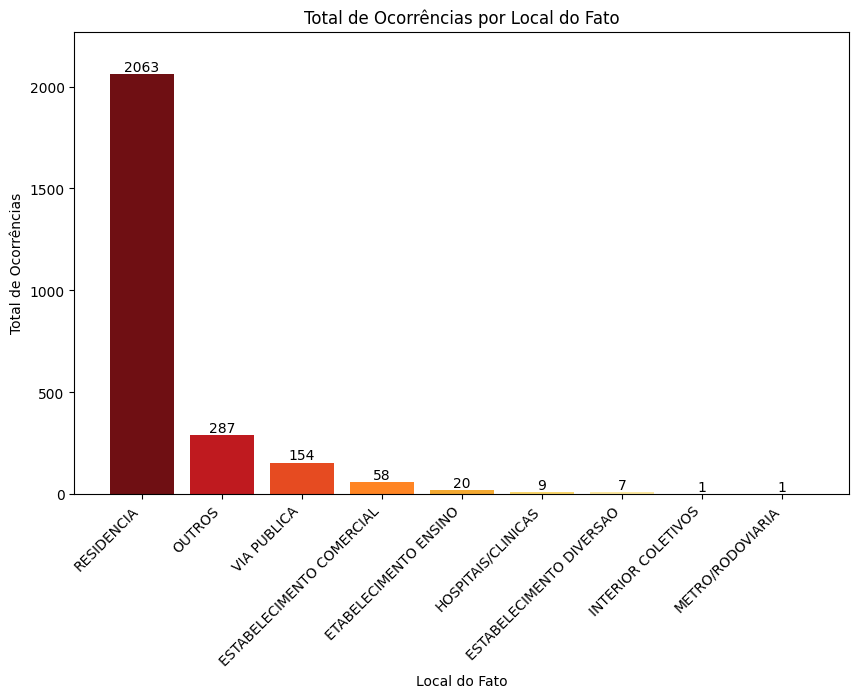

In [161]:
# Filtrando o DataFrame para crimes cometidos contra mulheres
filtered_df = df_sl[~df_sl['Classificação Segurança Mulheres'].isin(['Outros', 'Furto/Roubo'])]

# Calculando o total de ocorrências por local do fato
crime_counts_local = filtered_df['Local Fato'].value_counts()

# Convertendo o resultado para um DataFrame para facilitar a plotagem
crime_counts_local_df = crime_counts_local.reset_index()
crime_counts_local_df.columns = ['Local Fato', 'Total de Ocorrências']

# Cores do gráfico, similares às do gráfico fornecido
colors = ["#6F0F13", "#BF1A1F", "#E64B21", "#FF8524", "#F3A932", "#F8D56B", "#FBE79F", "#FBF4D1"]

# Criando o gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(crime_counts_local_df['Local Fato'], crime_counts_local_df['Total de Ocorrências'], color=colors[:len(crime_counts_local_df)])
plt.xlabel('Local do Fato')
plt.ylabel('Total de Ocorrências')
plt.xticks(rotation=45, ha='right')
plt.title('Total de Ocorrências por Local do Fato')

# Ajustando o limite do eixo Y para evitar sobreposição com o topo
plt.ylim(0, crime_counts_local_df['Total de Ocorrências'].max() * 1.1)

# Adicionando o total acima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{int(yval)}', ha='center', va='bottom')

plt.show()

### **Crimes por período do dia**

🔹 **Crimes de Lesão corporal por período do dia**

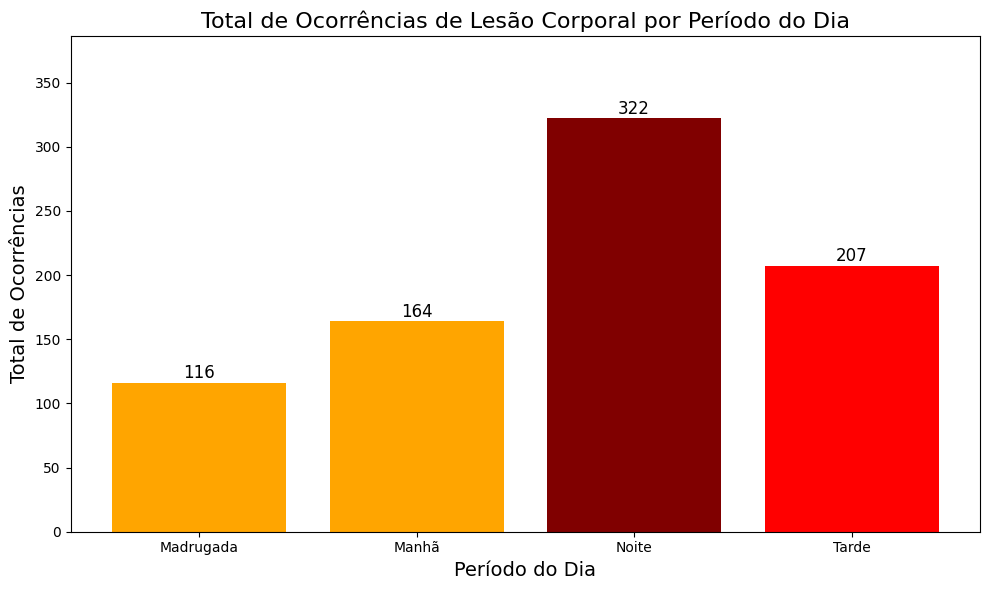

In [107]:
# Filtrar as ocorrências de "Lesão corporal"
df_lesao_corporal = df_sl[df_sl['Classificação Segurança Mulheres'] == 'Lesao corporal']

# Contar o total de ocorrências por Período do Dia
ocorrencias_por_periodo = df_lesao_corporal['Período do Dia'].value_counts().sort_index()

cores = ['#800000', 'red', 'orange']

# Determinar as faixas para cada cor
max_val = ocorrencias_por_periodo.max()
min_val = ocorrencias_por_periodo.min()
intervalo = (max_val - min_val) / 3

# Função para definir a cor com base no valor
def get_color(value):
    if value >= min_val + 2 * intervalo:
        return cores[0]
    elif value >= min_val + intervalo:
        return cores[1]
    else:
        return cores[2]

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(ocorrencias_por_periodo.index,
               ocorrencias_por_periodo.values,
               color=[get_color(value) for value in ocorrencias_por_periodo.values])

plt.ylim(0, ocorrencias_por_periodo.values.max() * 1.2)

# Adicionar rótulos e título
plt.xlabel('Período do Dia', fontsize=14)
plt.ylabel('Total de Ocorrências', fontsize=14)
plt.title('Total de Ocorrências de Lesão Corporal por Período do Dia', fontsize=16)

# Adicionar os valores das ocorrências
for i, total in enumerate(ocorrencias_por_periodo.values):
    plt.text(i, total + 0.5, f'{total}', ha='center', va='bottom', fontsize=12)

# Exibir o gráfico
plt.tight_layout()
plt.show()

🔹 **Crimes de Estupro por período do dia**

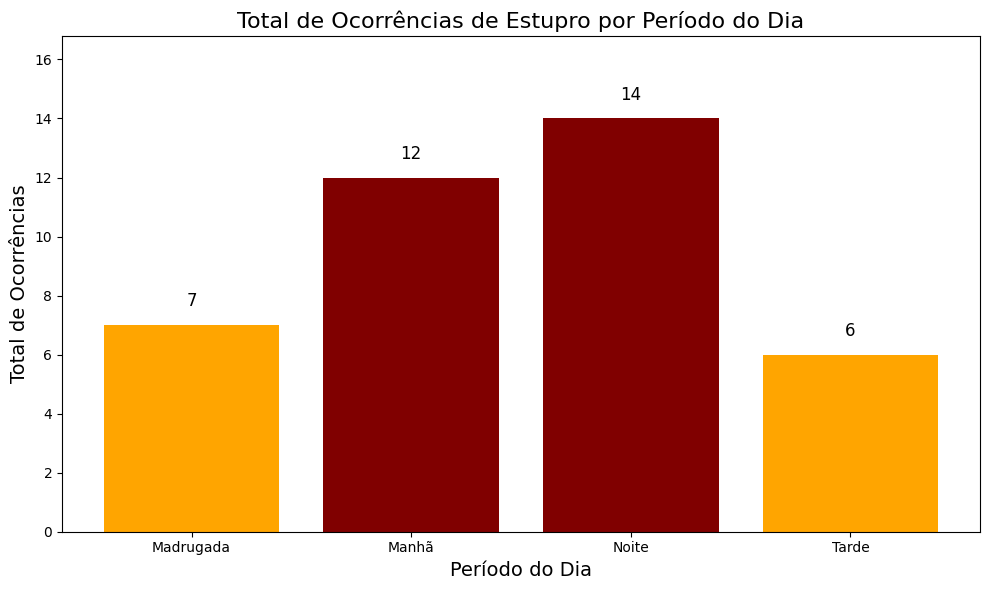

In [108]:
# Filtrar as ocorrências de "Estupro"
df_lesao_corporal = df_sl[df_sl['Classificação Segurança Mulheres'] == 'Estupro']

# Contar o total de ocorrências por Período do Dia
ocorrencias_por_periodo = df_lesao_corporal['Período do Dia'].value_counts().sort_index()

cores = ['#800000', 'red', 'orange']

# Determinar as faixas para cada cor
max_val = ocorrencias_por_periodo.max()
min_val = ocorrencias_por_periodo.min()
intervalo = (max_val - min_val) / 3

def get_color(value):
    if value >= min_val + 2 * intervalo:
        return cores[0]
    elif value >= min_val + intervalo:
        return cores[1]
    else:
        return cores[2]

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(ocorrencias_por_periodo.index,
               ocorrencias_por_periodo.values,
               color=[get_color(value) for value in ocorrencias_por_periodo.values])

plt.ylim(0, ocorrencias_por_periodo.values.max() * 1.2)

# Adicionar rótulos e título
plt.xlabel('Período do Dia', fontsize=14)
plt.ylabel('Total de Ocorrências', fontsize=14)
plt.title('Total de Ocorrências de Estupro por Período do Dia', fontsize=16)

# Adicionar os valores das ocorrências
for i, total in enumerate(ocorrencias_por_periodo.values):
    plt.text(i, total + 0.5, f'{total}', ha='center', va='bottom', fontsize=12)

# Exibir o gráfico
plt.tight_layout()
plt.show()

🔹 **Crimes de Estupro de vulnerável por período do dia**

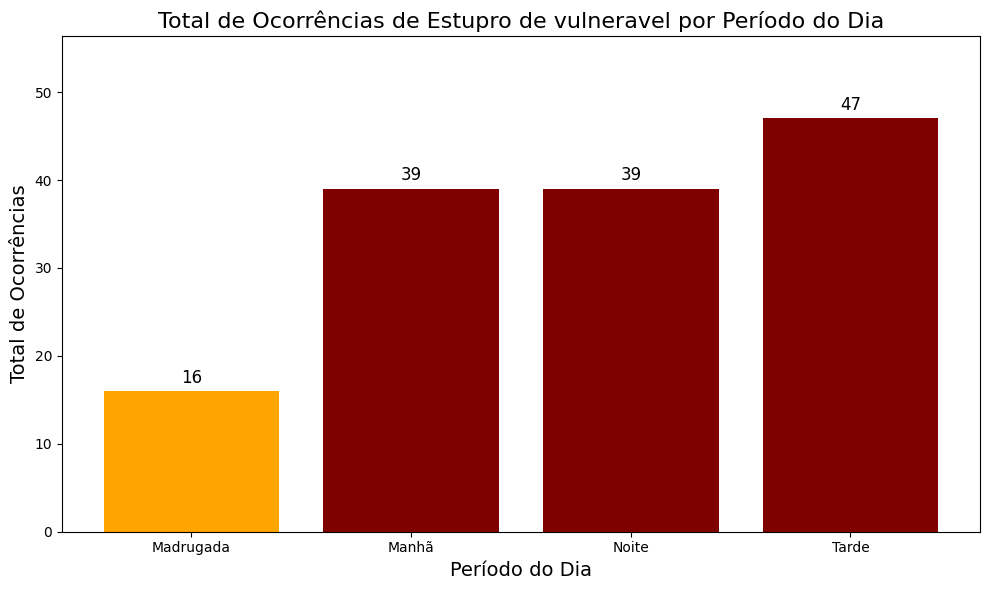

In [109]:
# Filtrar as ocorrências de "Estupro de vulnerável"
df_lesao_corporal = df_sl[df_sl['Classificação Segurança Mulheres'] == 'Estupro de vulneravel']

# Contar o total de ocorrências por Período do Dia
ocorrencias_por_periodo = df_lesao_corporal['Período do Dia'].value_counts().sort_index()

cores = ['#800000', 'red', 'orange']

# Determinar as faixas para cada cor
max_val = ocorrencias_por_periodo.max()
min_val = ocorrencias_por_periodo.min()
intervalo = (max_val - min_val) / 3

def get_color(value):
    if value >= min_val + 2 * intervalo:
        return cores[0]
    elif value >= min_val + intervalo:
        return cores[1]
    else:
        return cores[2]

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(ocorrencias_por_periodo.index,
               ocorrencias_por_periodo.values,
               color=[get_color(value) for value in ocorrencias_por_periodo.values])

plt.ylim(0, ocorrencias_por_periodo.values.max() * 1.2)

# Adicionar rótulos e título
plt.xlabel('Período do Dia', fontsize=14)
plt.ylabel('Total de Ocorrências', fontsize=14)
plt.title('Total de Ocorrências de Estupro de vulneravel por Período do Dia', fontsize=16)

# Adicionar os valores das ocorrências
for i, total in enumerate(ocorrencias_por_periodo.values):
    plt.text(i, total + 0.5, f'{total}', ha='center', va='bottom', fontsize=12)

# Exibir o gráfico
plt.tight_layout()
plt.show()

### **Crimes por local**

🔹 **Crimes contra a mulher por local**

<ipython-input-110-6bddbf02f64a>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("YlOrRd")


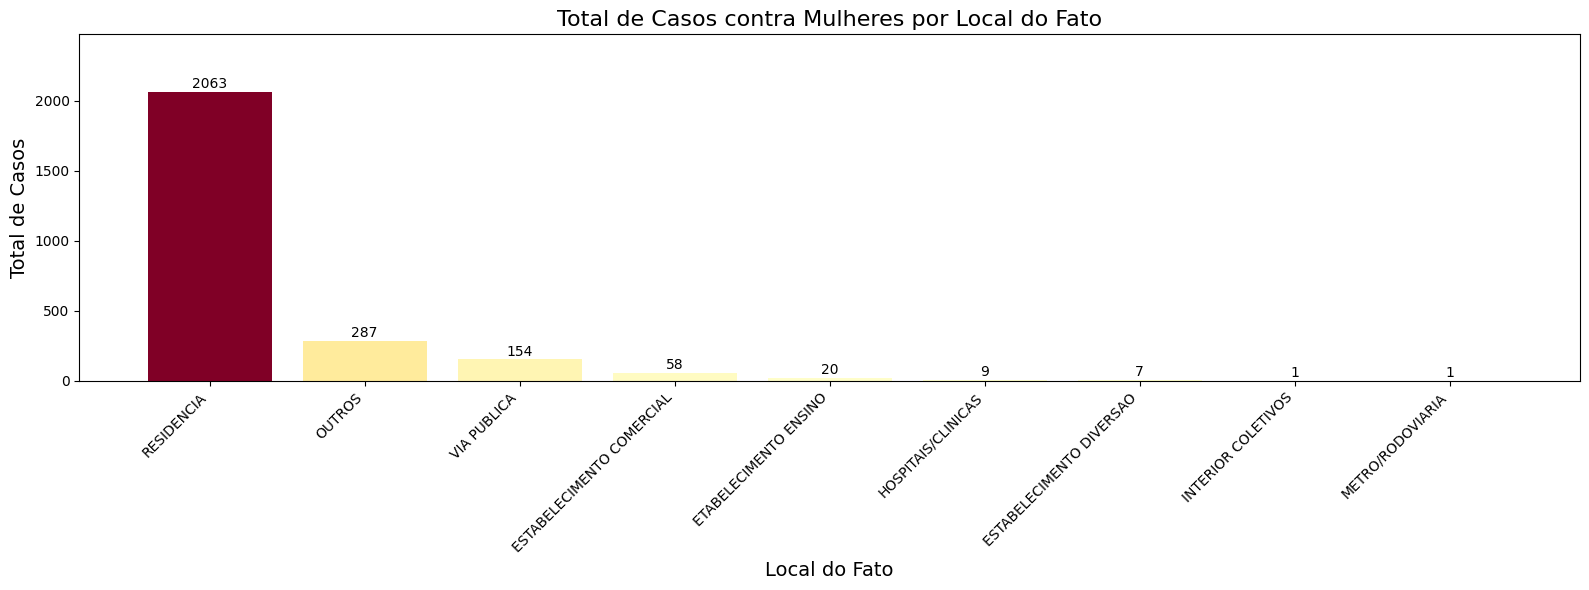

In [110]:
# Filtrar apenas os casos contra mulheres
df_contra_mulheres = df_sl[(df_sl['Classificação Segurança Mulheres'] != 'Outros') &
                           (df_sl['Classificação Segurança Mulheres'] != 'Furto/Roubo')]

# Contar o total de casos por Local Fato
total_casos_por_local = df_contra_mulheres['Local Fato'].value_counts().reset_index()
total_casos_por_local.columns = ['Local Fato', 'Total de Casos']

# Ordenar os dados do maior para o menor para uma melhor visualização
total_casos_por_local = total_casos_por_local.sort_values(by='Total de Casos', ascending=False)

cmap = plt.cm.get_cmap("YlOrRd")

# Normalizar os valores para aplicar o gradiente de cores
norm = mcolors.Normalize(vmin=total_casos_por_local['Total de Casos'].min(),
                         vmax=total_casos_por_local['Total de Casos'].max())

# Criar o gráfico de barras
plt.figure(figsize=(16, 6))
bars = plt.bar(total_casos_por_local['Local Fato'],
               total_casos_por_local['Total de Casos'],
               color=[cmap(norm(value)) for value in total_casos_por_local['Total de Casos']])

plt.ylim(0, total_casos_por_local['Total de Casos'].max() * 1.2)

# Adicionar rótulos e título
plt.xlabel('Local do Fato', fontsize=14)
plt.ylabel('Total de Casos', fontsize=14)
plt.title('Total de Casos contra Mulheres por Local do Fato', fontsize=16)
plt.xticks(rotation=45, ha='right')

# Adicionar os valores dos casos
for i, total in enumerate(total_casos_por_local['Total de Casos']):
    plt.text(i, total + 5, f'{total}', ha='center', va='bottom', fontsize=10)

# Ajustar o layout e exibir o gráfico
plt.tight_layout()
plt.show()

🔹 **Crimes de Lesão corporal por local**

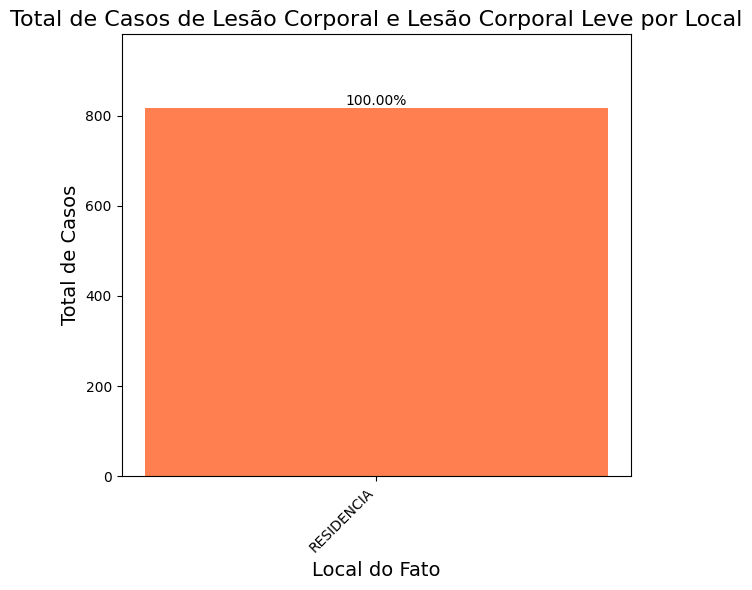

In [111]:
# Filtrar apenas os casos de "Lesao corporal" e "Lesao corporal leve"
df_lesao = df_sl[df_sl['Classificação Segurança Mulheres'].isin(['Lesao corporal', 'Lesao corporal leve'])]

# Contar o total de casos por Local Fato
total_casos_por_local = df_lesao['Local Fato'].value_counts().reset_index()
total_casos_por_local.columns = ['Local Fato', 'Total de Casos']

# Calcular o total geral de casos para calcular a porcentagem
total_geral_casos = total_casos_por_local['Total de Casos'].sum()

# Criar o gráfico de barras
plt.figure(figsize=(6, 6))
bars = plt.bar(total_casos_por_local['Local Fato'], total_casos_por_local['Total de Casos'], color='coral')

# Adicionar rótulos e título
plt.xlabel('Local do Fato', fontsize=14)
plt.ylabel('Total de Casos', fontsize=14)
plt.title('Total de Casos de Lesão Corporal e Lesão Corporal Leve por Local', fontsize=16)
plt.xticks(rotation=45, ha='right')

# Adicionar a porcentagem
for i, total in enumerate(total_casos_por_local['Total de Casos']):
    porcentagem = (total / total_geral_casos) * 100
    plt.text(i, total + 1, f'{porcentagem:.2f}%', ha='center', va='bottom', fontsize=10)

# Ajustar o layout e exibir o gráfico
plt.ylim(0, total_casos_por_local['Total de Casos'].max() * 1.2)
plt.tight_layout()
plt.show()

🔹 **Crimes de Estupro por local**

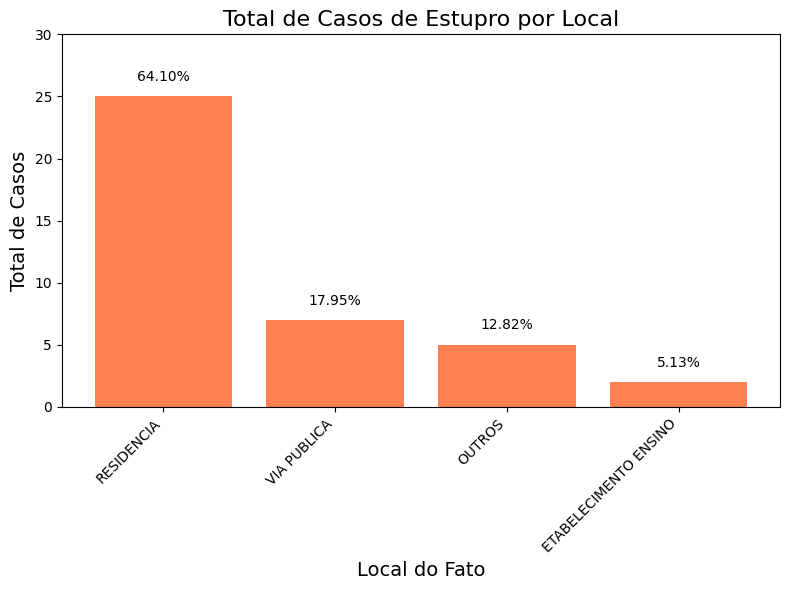

In [112]:
# Filtrar apenas os casos de "Estupro"
df_estupro = df_sl[df_sl['Classificação Segurança Mulheres'] == 'Estupro']

# Contar o total de casos por Local Fato
total_casos_por_local = df_estupro['Local Fato'].value_counts().reset_index()
total_casos_por_local.columns = ['Local Fato', 'Total de Casos']

# Calcular o total geral de casos para calcular a porcentagem
total_geral_casos = total_casos_por_local['Total de Casos'].sum()

# Criar o gráfico de barras
plt.figure(figsize=(8, 6))
bars = plt.bar(total_casos_por_local['Local Fato'], total_casos_por_local['Total de Casos'], color='coral')

# Adicionar rótulos e título
plt.xlabel('Local do Fato', fontsize=14)
plt.ylabel('Total de Casos', fontsize=14)
plt.title('Total de Casos de Estupro por Local', fontsize=16)
plt.xticks(rotation=45, ha='right')

# Adicionar a porcentagem
for i, total in enumerate(total_casos_por_local['Total de Casos']):
    porcentagem = (total / total_geral_casos) * 100
    plt.text(i, total + 1, f'{porcentagem:.2f}%', ha='center', va='bottom', fontsize=10)

# Ajustar o layout e exibir o gráfico
plt.ylim(0, total_casos_por_local['Total de Casos'].max() * 1.2)
plt.tight_layout()
plt.show()

🔹 **Crimes de Estupro de vulnerável por local**

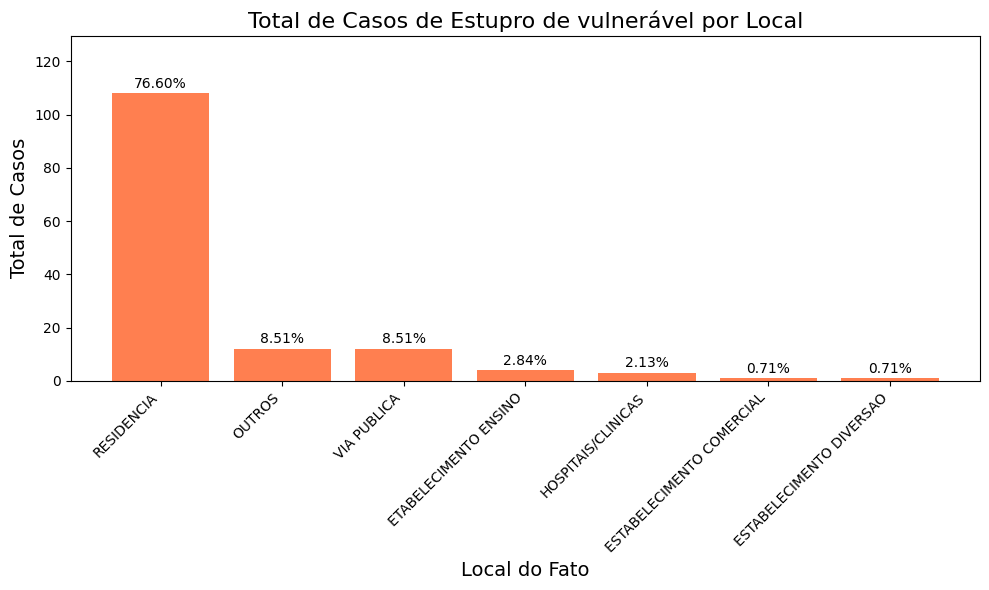

In [113]:
# Filtrar apenas os casos de "Estupro de vulneravel"
df_estupro_vulneravel = df_sl[df_sl['Classificação Segurança Mulheres'] == 'Estupro de vulneravel']

# Contar o total de casos por Local Fato
total_casos_por_local = df_estupro_vulneravel['Local Fato'].value_counts().reset_index()
total_casos_por_local.columns = ['Local Fato', 'Total de Casos']

# Calcular o total geral de casos para calcular a porcentagem
total_geral_casos = total_casos_por_local['Total de Casos'].sum()

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(total_casos_por_local['Local Fato'], total_casos_por_local['Total de Casos'], color='coral')

# Adicionar rótulos e título
plt.xlabel('Local do Fato', fontsize=14)
plt.ylabel('Total de Casos', fontsize=14)
plt.title('Total de Casos de Estupro de vulnerável por Local', fontsize=16)
plt.xticks(rotation=45, ha='right')

# Adicionar a porcentagem
for i, total in enumerate(total_casos_por_local['Total de Casos']):
    porcentagem = (total / total_geral_casos) * 100
    plt.text(i, total + 1, f'{porcentagem:.2f}%', ha='center', va='bottom', fontsize=10)

# Ajustar o layout e exibir o gráfico
plt.ylim(0, total_casos_por_local['Total de Casos'].max() * 1.2)
plt.tight_layout()
plt.show()

# ☁ **Nuvem de palavras**

In [114]:
from wordcloud import WordCloud
from matplotlib.colors import LinearSegmentedColormap
import random

### 🔹 **Nuvem de Palavras dos Bairros com Maior Incidência de Estupro e Estupro de Vulnerável**

In [115]:
# Filtrar apenas os crimes de 'Estupro' e 'Estupro de vulneravel'
df_estupro = df_sl[df_sl['Classificação Segurança Mulheres'].isin(['Estupro', 'Estupro de vulneravel'])]

# Contar a frequência de cada bairro para esses crimes
bairro_counts = df_estupro['Bairro Classificação'].value_counts()

# Definir uma paleta personalizada de rosa mais intensa
pink_colors = LinearSegmentedColormap.from_list("custom_pink", ["#ffb6c1", "#ff69b4", "#ff1493", "#db0073"])

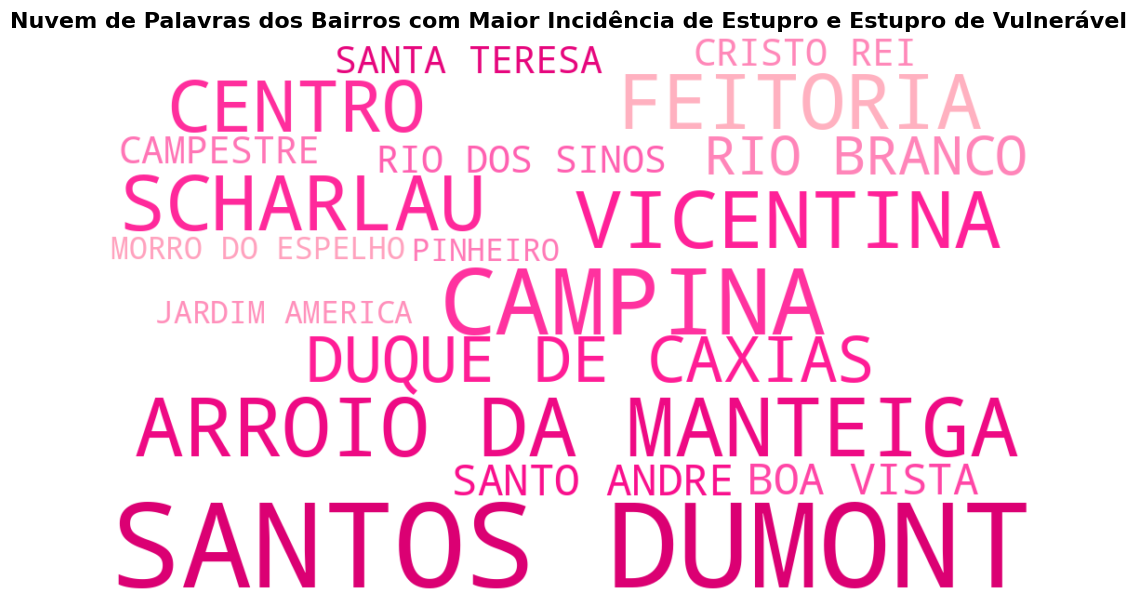

In [116]:
wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    colormap=pink_colors,
    relative_scaling=0.5,
    max_font_size=150,
    min_font_size=10,
    font_path=None,
    prefer_horizontal=1.0
).generate_from_frequencies(bairro_counts)

# Exibir a nuvem de palavras
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras dos Bairros com Maior Incidência de Estupro e Estupro de Vulnerável', fontsize=16, fontweight='bold')
plt.show()

### 🔹 **Nuvem de Palavras dos Bairros com Maior Incidência de Importunacao sexual e Assedio sexual**

In [117]:
# Filtrar apenas os crimes de 'Importunacao sexual' e 'Assedio sexual'
df_importunacao_estupro_sexual = df_sl[df_sl['Classificação Segurança Mulheres'].isin(['Importunacao sexual', 'Assedio sexual'])]

# Contar a frequência de cada bairro para esses crimes
bairro_counts = df_importunacao_estupro_sexual['Bairro Classificação'].value_counts()

# Definir uma paleta personalizada de verdes
green_colors = LinearSegmentedColormap.from_list("custom_green", ["#a8e6cf", "#00ff00", "#32cd32", "#228b22", "#006400"])

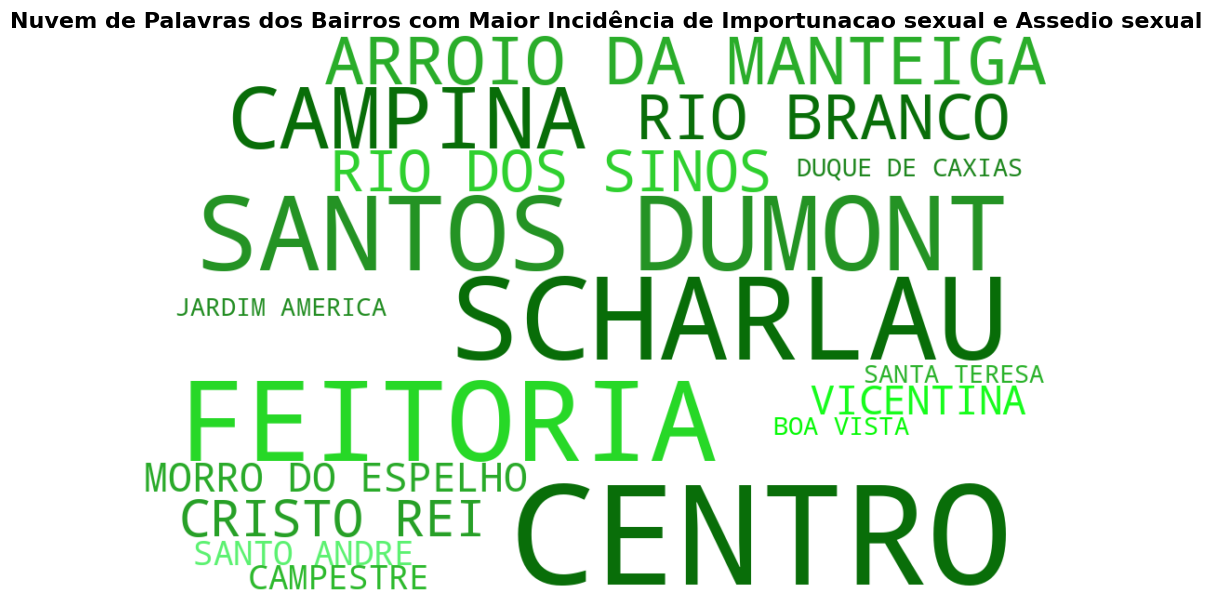

In [118]:
wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    colormap=green_colors,
    relative_scaling=0.5,
    max_font_size=150,
    min_font_size=10,
    prefer_horizontal=1.0
).generate_from_frequencies(bairro_counts)

# Exibir a nuvem de palavras
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras dos Bairros com Maior Incidência de Importunacao sexual e Assedio sexual', fontsize=16, fontweight='bold')
plt.show()

### 🔹 **Nuvem de Palavras dos Bairros com Maior Incidência de Descumprimento de medida protetiva**

In [119]:
# Filtrar apenas os crimes de 'Descumprimento de medida protetiva'
df_descumprimento = df_sl[df_sl['Classificação Segurança Mulheres'] == 'Descumprimento de medida protetiva']

# Contar a frequência de cada bairro para esses crimes
bairro_counts = df_descumprimento['Bairro Classificação'].value_counts()

# Definir uma paleta personalizada de tons de azul
blue_colors = LinearSegmentedColormap.from_list("custom_blue", ["#add8e6", "#87ceeb", "#4682b4", "#1e90ff", "#00008b"])

In [120]:
# Função para colorir as palavras com base na frequência
def blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    # Quanto maior a palavra, mais escura a cor
    if font_size > 100:
        return "#00008b"
    elif font_size > 75:
        return "#1e90ff"
    elif font_size > 50:
        return "#4682b4"
    elif font_size > 25:
        return "#87ceeb"
    else:
        return "#add8e6"

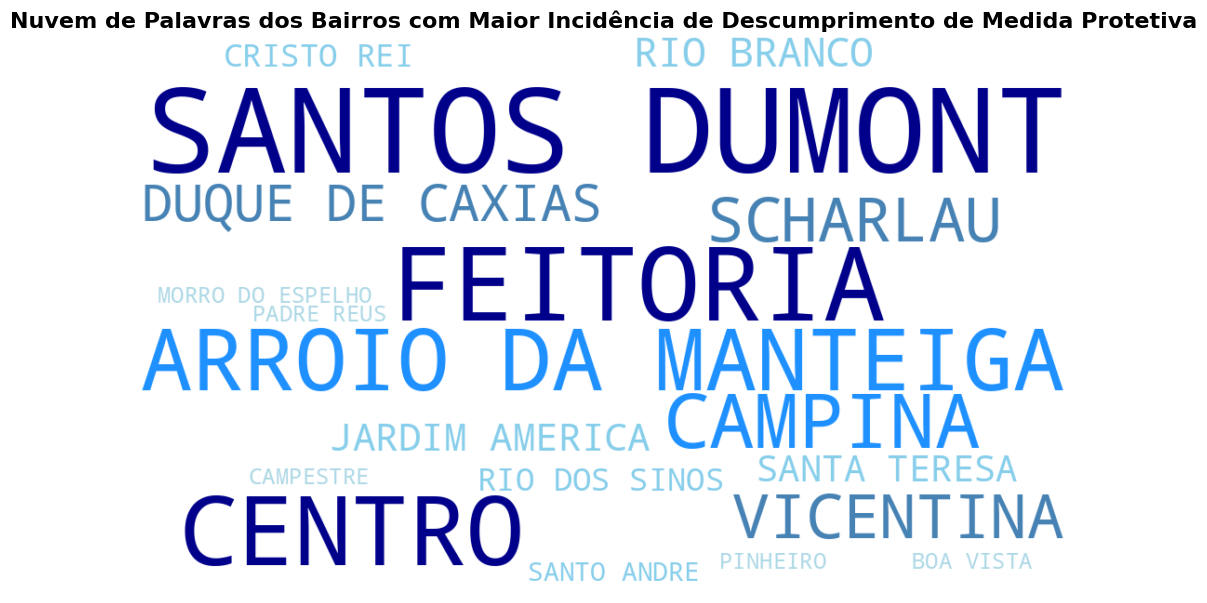

In [121]:
wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    color_func=blue_color_func,  # Aplica a função de cor personalizada
    relative_scaling=0.5,       # Escala relativa para dar destaque a palavras maiores
    max_font_size=150,          # Aumenta o tamanho máximo da fonte
    min_font_size=10,           # Define o tamanho mínimo da fonte
    prefer_horizontal=1.0       # Prefere palavras na horizontal para melhorar o impacto visual
).generate_from_frequencies(bairro_counts)

# Exibir a nuvem de palavras
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras dos Bairros com Maior Incidência de Descumprimento de Medida Protetiva', fontsize=16, fontweight='bold')
plt.show()

# 📈 **Deep learning - Crimes contra a mulher em São Leopoldo**

### Edições

In [122]:
# Filtrar apenas os crimes contra mulheres
df_mulheres = df_sl[(df_sl['Classificação Segurança Mulheres'] != 'Outros') &
                    (df_sl['Classificação Segurança Mulheres'] != 'Furto/Roubo')]

In [123]:
# Agrupar e contar o número de crimes contra mulheres por 'Bairro Classificação'
bairros_contagem = df_mulheres.groupby('Bairro Classificação').size().reset_index(name='Contagem_Casos')

In [124]:
# Função de classificação de risco
def classificar_bairro(contagem):
    if contagem == 0:
        return 'Seguro'
    elif 1 <= contagem <= 10:
        return 'Seguro'
    elif 11 <= contagem <= 50:
        return 'Inseguro'
    else:
        return 'Muito Inseguro'

# Aplicar a classificação
bairros_contagem['Classificacao_Risco'] = bairros_contagem['Contagem_Casos'].apply(classificar_bairro)

### **Aplicação do modelo de aprendizado de máquina**

In [125]:
from sklearn.preprocessing import LabelEncoder

In [126]:
# Codificar a coluna de classificação de risco em valores numéricos
le = LabelEncoder()
bairros_contagem['Classificacao_Risco_Num'] = le.fit_transform(bairros_contagem['Classificacao_Risco'])

In [127]:
from sklearn.model_selection import train_test_split

In [128]:
# Separar as features (contagem de casos) e o target (classificação de risco numérico)
X = bairros_contagem[['Contagem_Casos']].values
y = bairros_contagem['Classificacao_Risco_Num'].values

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [129]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [130]:
# Construção do modelo de deep learning
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 saídas para cada nível de classificação

# Compilação do modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Treinamento do modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 0.5417 - loss: 0.7737 - val_accuracy: 0.8000 - val_loss: 0.2633
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5000 - loss: 0.6541 - val_accuracy: 0.8000 - val_loss: 0.2519
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5833 - loss: 0.5231 - val_accuracy: 0.8000 - val_loss: 0.2559
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5417 - loss: 0.5590 - val_accuracy: 0.8000 - val_loss: 0.2519
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5417 - loss: 0.5647 - val_accuracy: 0.8000 - val_loss: 0.2484
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5833 - loss: 0.5355 - val_accuracy: 0.8000 - val_loss: 0.2453
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5000 - loss: 0.5907 - val_accuracy: 0.8000 - val_loss: 0.2442
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5000 - loss: 0.5944 - val_accuracy: 0.8000 - val_loss: 0.2432
Epoch 9/50

In [131]:
# Avaliação do modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Acurácia do modelo: {accuracy * 100:.2f}%')

# Exibir o mapeamento da classificação
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Mapping de Classificação:", mapping)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.1923
Acurácia do modelo: 100.00%
Mapping de Classificação: {'Inseguro': 0, 'Muito Inseguro': 1, 'Seguro': 2}


### **Gráficos**

🔹 **Bairros por Classificação de Risco**

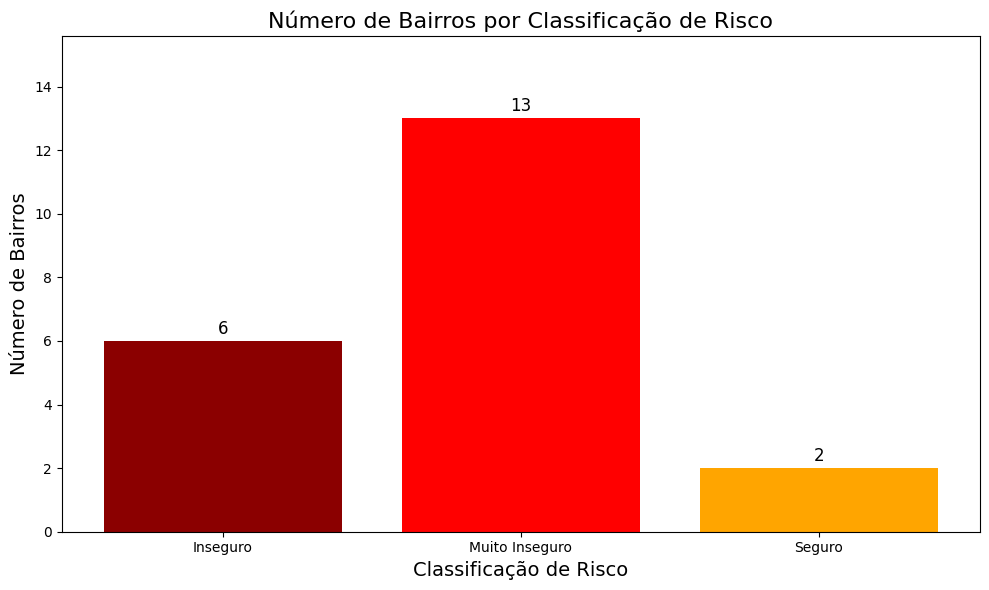

In [132]:
# Contar o número de bairros por Classificacao_Risco
bairros_por_risco = bairros_contagem.groupby('Classificacao_Risco')['Bairro Classificação'].count().reset_index()
bairros_por_risco.columns = ['Classificacao_Risco', 'Quantidade_Bairros']

cores = ['#8B0000', 'red', 'orange', 'yellow']

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(bairros_por_risco['Classificacao_Risco'],
               bairros_por_risco['Quantidade_Bairros'],
               color=cores[:len(bairros_por_risco)])  # Aplica as cores

plt.ylim(0, bairros_por_risco['Quantidade_Bairros'].max() * 1.2)

# Adicionar rótulos e título
plt.xlabel('Classificação de Risco', fontsize=14)
plt.ylabel('Número de Bairros', fontsize=14)
plt.title('Número de Bairros por Classificação de Risco', fontsize=16)

# Adicionar os valores no topo de cada barra
for i, total in enumerate(bairros_por_risco['Quantidade_Bairros']):
    plt.text(i, total + 0.1, f'{total}', ha='center', va='bottom', fontsize=12)

# Ajustar o layout e exibir o gráfico
plt.tight_layout()
plt.show()

🔹 **Bairros classificados como Muito Inseguros**

<ipython-input-133-87a861af071c>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("YlOrRd")


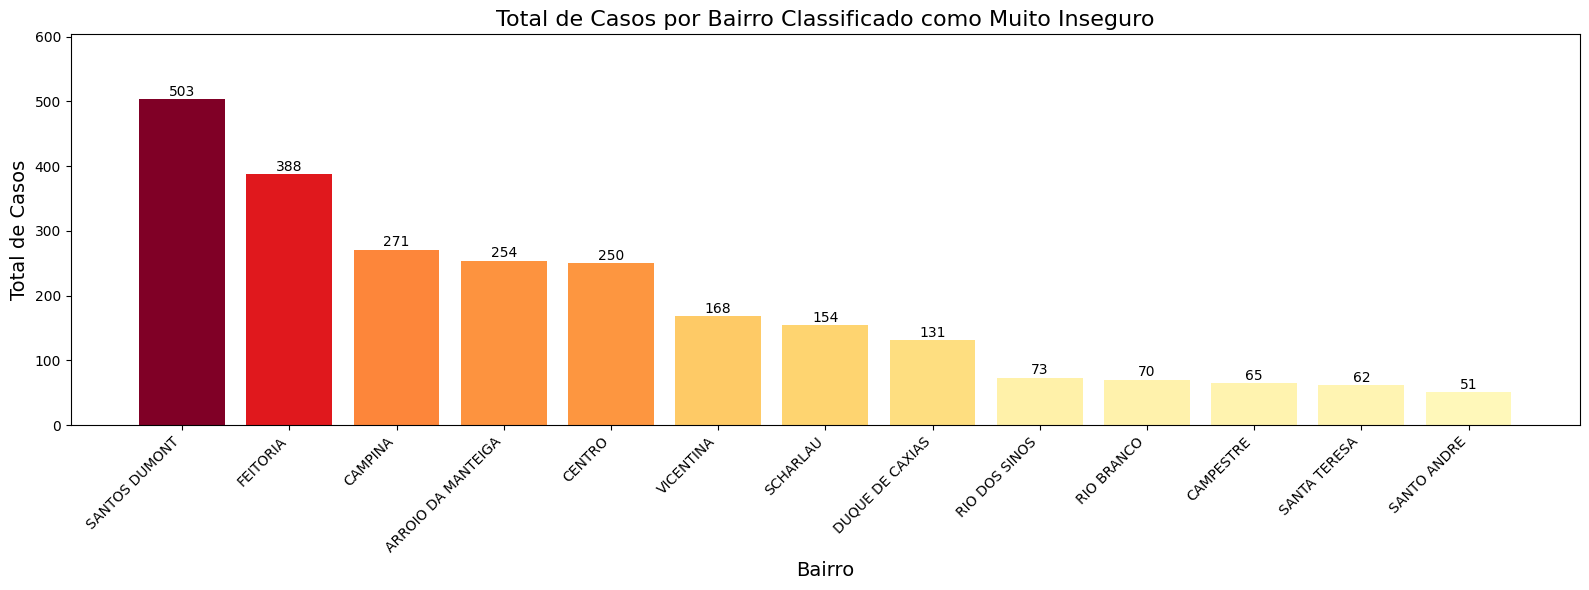

In [133]:
# Filtrar e ordenar os bairros classificados como "Muito Inseguro" pelo número de casos
bairros_muito_inseguros = bairros_contagem[bairros_contagem['Classificacao_Risco'] == 'Muito Inseguro']
bairros_muito_inseguros = bairros_muito_inseguros.sort_values(by='Contagem_Casos', ascending=False)

cmap = plt.cm.get_cmap("YlOrRd")
norm = mcolors.Normalize(vmin=bairros_muito_inseguros['Contagem_Casos'].min() * 0.5,
                         vmax=bairros_muito_inseguros['Contagem_Casos'].max())

plt.figure(figsize=(16, 6))
bars = plt.bar(bairros_muito_inseguros['Bairro Classificação'],
               bairros_muito_inseguros['Contagem_Casos'],
               color=[cmap(norm(value)) for value in bairros_muito_inseguros['Contagem_Casos']])

plt.ylim(0, bairros_muito_inseguros['Contagem_Casos'].max() * 1.2)

# Adicionar rótulos e título
plt.xlabel('Bairro', fontsize=14)
plt.ylabel('Total de Casos', fontsize=14)
plt.title('Total de Casos por Bairro Classificado como Muito Inseguro', fontsize=16)
plt.xticks(rotation=45, ha='right')

# Adicionar os valores dos casos no topo de cada barra
for i, total in enumerate(bairros_muito_inseguros['Contagem_Casos']):
    plt.text(i, total + 0.5, f'{total}', ha='center', va='bottom', fontsize=10)

# Ajustar o layout e exibir o gráfico
plt.tight_layout()
plt.show()

🔹 **Bairros classificados como Inseguros**

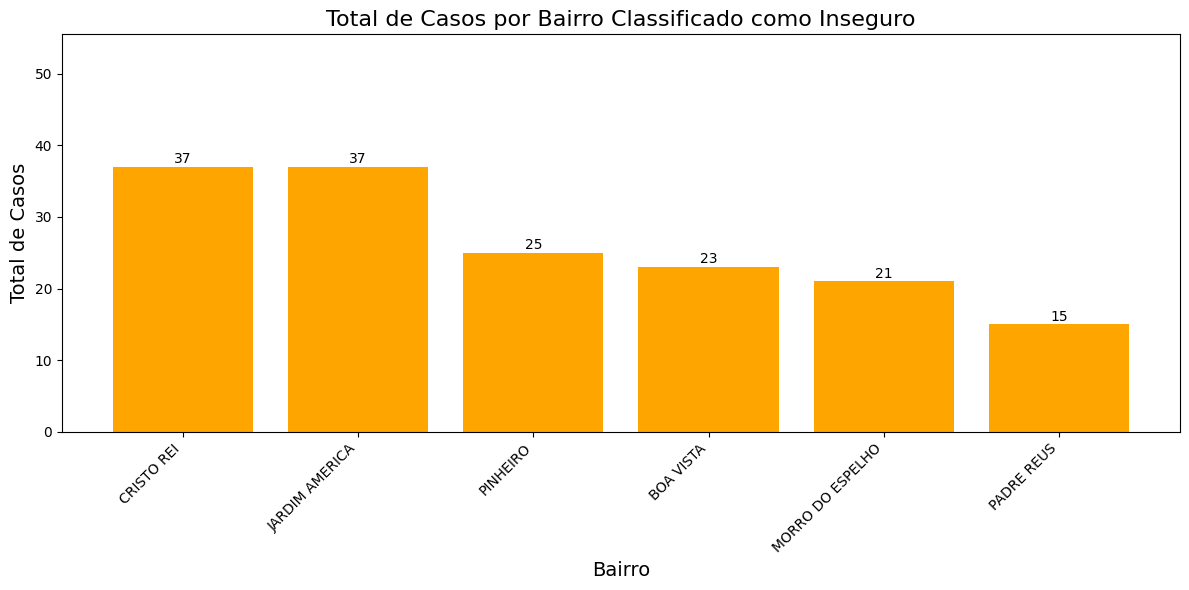

In [134]:
# Filtrar e ordenar os bairros classificados como "Inseguro" pelo número de casos
bairros_inseguros = bairros_contagem[bairros_contagem['Classificacao_Risco'] == 'Inseguro']
bairros_inseguros = bairros_inseguros.sort_values(by='Contagem_Casos', ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(bairros_inseguros['Bairro Classificação'],
               bairros_inseguros['Contagem_Casos'],
               color='orange')

plt.ylim(0, bairros_inseguros['Contagem_Casos'].max() * 1.5)

# Adicionar rótulos e título
plt.xlabel('Bairro', fontsize=14)
plt.ylabel('Total de Casos', fontsize=14)
plt.title('Total de Casos por Bairro Classificado como Inseguro', fontsize=16)
plt.xticks(rotation=45, ha='right')

# Adicionar os valores dos casos no topo de cada barra
for i, total in enumerate(bairros_inseguros['Contagem_Casos']):
    plt.text(i, total + 0.1, f'{total}', ha='center', va='bottom', fontsize=10)

# Ajustar o layout e exibir o gráfico
plt.tight_layout()
plt.show()

🔹 **Bairros classificados como Seguros**

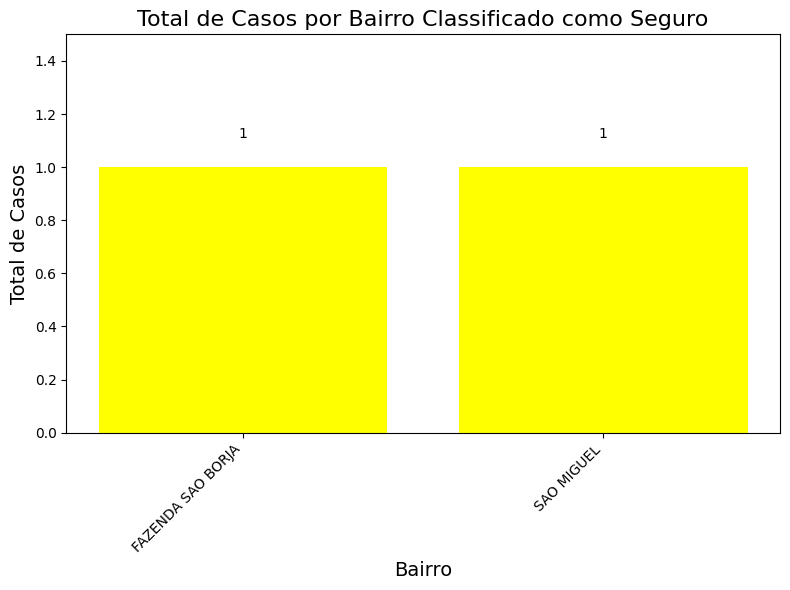

In [135]:
# Filtrar e ordenar os bairros classificados como "Seguro" pelo número de casos
bairros_seguros = bairros_contagem[bairros_contagem['Classificacao_Risco'] == 'Seguro']
bairros_seguros = bairros_seguros.sort_values(by='Contagem_Casos', ascending=False)

plt.figure(figsize=(8, 6))
bars = plt.bar(bairros_seguros['Bairro Classificação'],
               bairros_seguros['Contagem_Casos'],
               color='yellow')

plt.ylim(0, bairros_seguros['Contagem_Casos'].max() * 1.5)

# Adicionar rótulos e título
plt.xlabel('Bairro', fontsize=14)
plt.ylabel('Total de Casos', fontsize=14)
plt.title('Total de Casos por Bairro Classificado como Seguro', fontsize=16)
plt.xticks(rotation=45, ha='right')

# Adicionar os valores dos casos no topo de cada barra
for i, total in enumerate(bairros_seguros['Contagem_Casos']):
    plt.text(i, total + 0.1, f'{total}', ha='center', va='bottom', fontsize=10)

# Ajustar o layout e exibir o gráfico
plt.tight_layout()
plt.show()

# **Clusterização**

In [136]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime

### 🔹 **Crimes de Importunacao sexual e Assedio sexual**

In [137]:
# Filtrar apenas os crimes de 'Importunacao sexual' e 'Assedio sexual'
df_filtered = df_sl[df_sl['Classificação Segurança Mulheres'].isin(['Importunacao sexual', 'Assedio sexual'])]

# Selecionar apenas as colunas de interesse: 'Idade Vítima' e 'Bairro Classificação'
df_importunacao_assedio = df_filtered[['Idade Vítima', 'Bairro Classificação']].dropna()

# Padronizar a coluna de Idade para o KMeans
scaler = StandardScaler()
idade_scaled = scaler.fit_transform(df_importunacao_assedio[['Idade Vítima']])

# Definir o número de clusters
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
df_importunacao_assedio['Cluster'] = kmeans.fit_predict(idade_scaled)

# Criar o DataFrame df_idade
df_idade_importunacao_assedio = df_importunacao_assedio[['Idade Vítima', 'Cluster']]

# Adicionar os centros dos clusters como referência
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
df_idade_importunacao_assedio['Cluster Center'] = df_idade_importunacao_assedio['Cluster'].map(lambda x: cluster_centers[x][0])

# Exibir os resultados por cluster
resultado_cluster = df_idade_importunacao_assedio.groupby('Cluster').agg({'Idade Vítima': ['mean', 'min', 'max', 'count']})
resultado_cluster

Idade Vítima              
                mean min max count
Cluster                           
0          17.500000   8  25    68
1          55.307692  47  76    13
2          32.857143  26  44    21

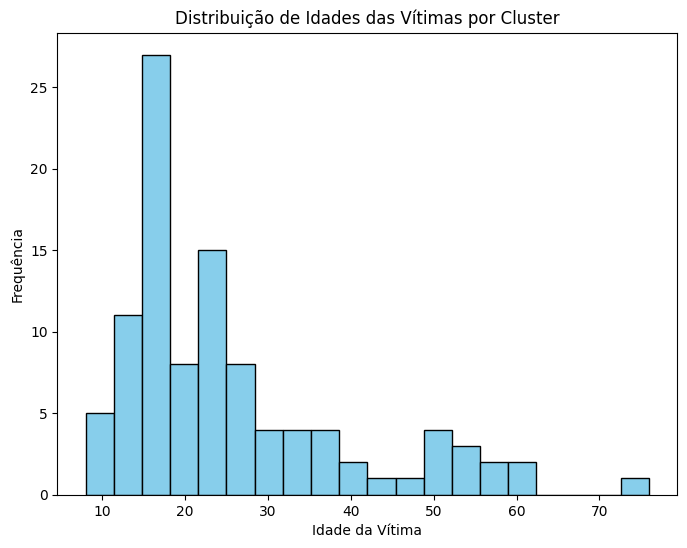

In [138]:
# Visualização dos clusters de idade
plt.figure(figsize=(8, 6))
plt.hist(df_idade_importunacao_assedio['Idade Vítima'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribuição de Idades das Vítimas por Cluster')
plt.xlabel('Idade da Vítima')
plt.ylabel('Frequência')
plt.show()

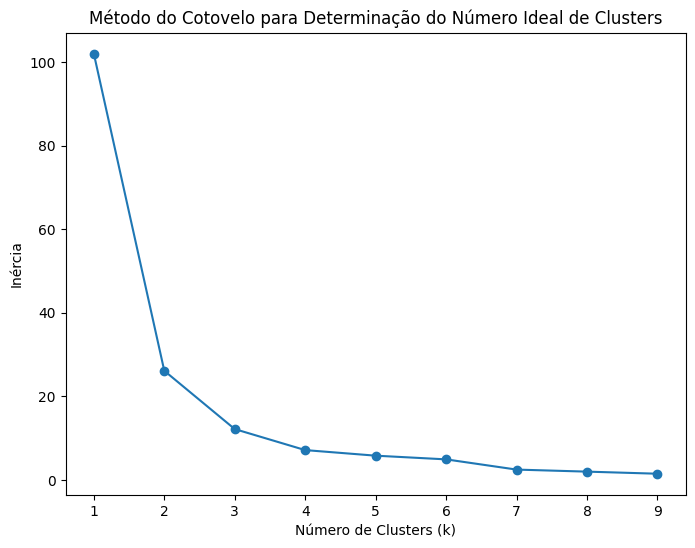

In [139]:
# Padronizar a coluna 'Idade Vítima' para clustering
scaler = StandardScaler()
idade_scaled = scaler.fit_transform(df_idade_importunacao_assedio[['Idade Vítima']])

# Calcular a inércia para diferentes números de clusters
inertias = []
k_values = range(1, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(idade_scaled)
    inertias.append(kmeans.inertia_)

# Plotar o gráfico do método do cotovelo
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertias, marker='o')
plt.title('Método do Cotovelo para Determinação do Número Ideal de Clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.show()

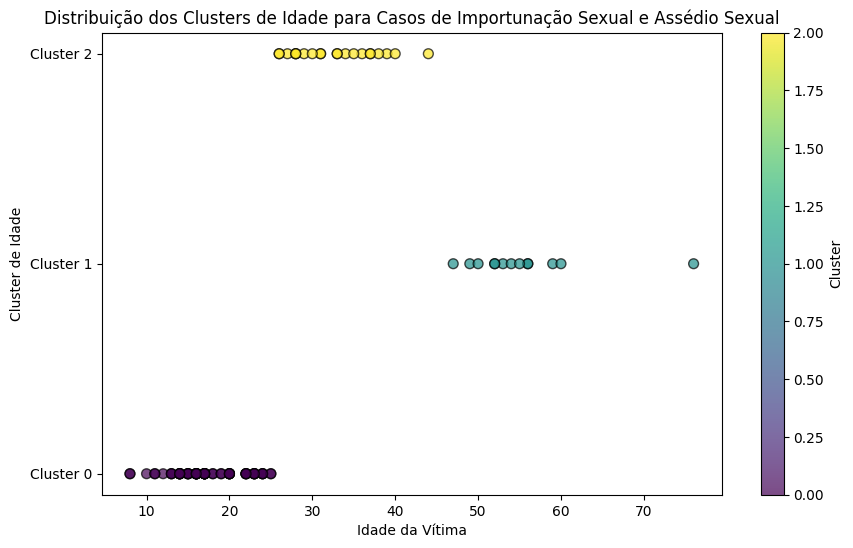

In [140]:
# Criar o gráfico de dispersão para a distribuição dos clusters de acordo com a idade (Importunação Sexual e Assédio Sexual)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_idade_importunacao_assedio['Idade Vítima'], df_idade_importunacao_assedio['Cluster'],
                      c=df_idade_importunacao_assedio['Cluster'], cmap='viridis', s=50, alpha=0.7, edgecolor='k')
plt.colorbar(scatter, label='Cluster')
plt.title('Distribuição dos Clusters de Idade para Casos de Importunação Sexual e Assédio Sexual')
plt.xlabel('Idade da Vítima')
plt.ylabel('Cluster de Idade')
plt.yticks(ticks=range(df_idade_importunacao_assedio['Cluster'].nunique()),
           labels=[f'Cluster {i}' for i in range(df_idade_importunacao_assedio['Cluster'].nunique())])

plt.show()

### 🔹 **Crimes de Lesão corporal**

In [141]:
# Filtrar apenas os crimes de 'Lesao Corporal' e 'Lesao Corporal Leve'
df_filtered_lesao = df_sl[df_sl['Classificação Segurança Mulheres'].isin(['Lesao corporal', 'Lesao corporal leve'])]

# Selecionar apenas as colunas de interesse: 'Idade Vítima' e 'Bairro Classificação'
df_lesao_corporal = df_filtered_lesao[['Idade Vítima', 'Bairro Classificação']].dropna()

# Padronizar a coluna de Idade para o KMeans
scaler = StandardScaler()
idade_scaled_lesao = scaler.fit_transform(df_lesao_corporal[['Idade Vítima']])

# Definir o número de clusters
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
df_lesao_corporal['Cluster'] = kmeans.fit_predict(idade_scaled_lesao)

# Criar o DataFrame df_idade_lesao
df_idade_lesao = df_lesao_corporal[['Idade Vítima', 'Cluster']]

# Adicionar os centros dos clusters como referência
cluster_centers_lesao = scaler.inverse_transform(kmeans.cluster_centers_)
df_idade_lesao['Cluster Center'] = df_idade_lesao['Cluster'].map(lambda x: cluster_centers_lesao[x][0])

# Exibir os resultados por cluster
resultado_cluster_lesao = df_idade_lesao.groupby('Cluster').agg({'Idade Vítima': ['mean', 'min', 'max', 'count']})
resultado_cluster_lesao

Idade Vítima              
                mean min max count
Cluster                           
0          42.268852  34  52   305
1          23.988372   3  33   430
2          62.170732  53  83    82

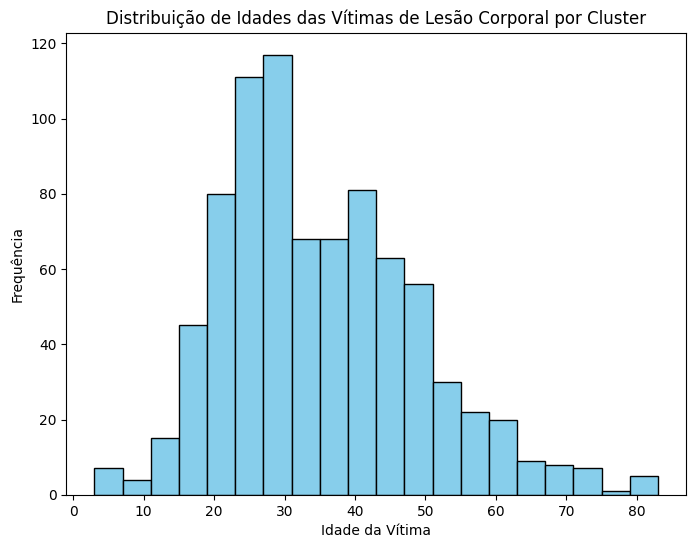

In [142]:
# Visualização dos clusters de idade para Lesão Corporal
plt.figure(figsize=(8, 6))
plt.hist(df_idade_lesao['Idade Vítima'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribuição de Idades das Vítimas de Lesão Corporal por Cluster')
plt.xlabel('Idade da Vítima')
plt.ylabel('Frequência')
plt.show()

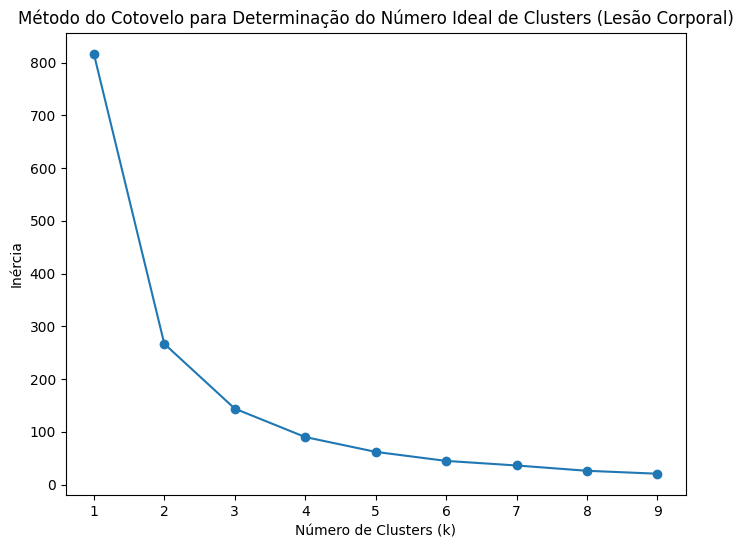

In [143]:
# Padronizar a coluna 'Idade Vítima' para clustering
idade_scaled_lesao = scaler.fit_transform(df_idade_lesao[['Idade Vítima']])

# Calcular a inércia para diferentes números de clusters
inertias_lesao = []
k_values = range(1, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(idade_scaled_lesao)
    inertias_lesao.append(kmeans.inertia_)

# Plotar o gráfico do método do cotovelo para Lesão Corporal
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertias_lesao, marker='o')
plt.title('Método do Cotovelo para Determinação do Número Ideal de Clusters (Lesão Corporal)')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.show()

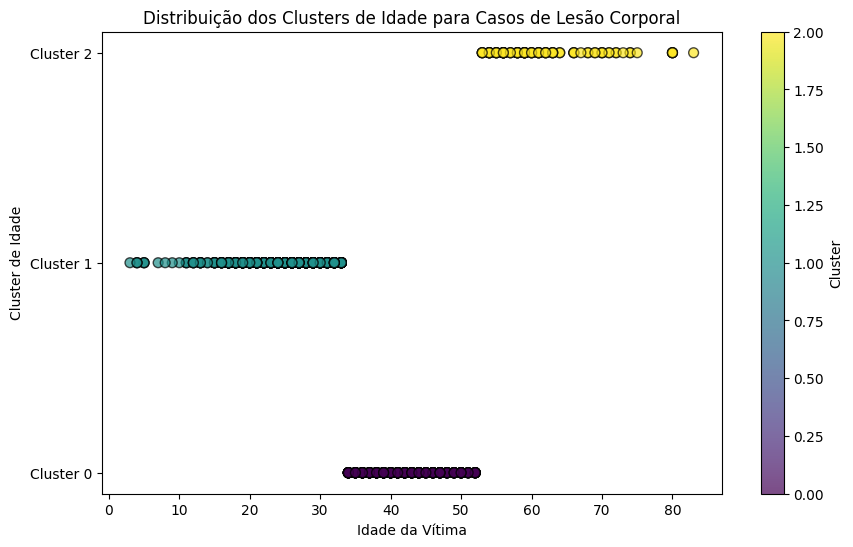

In [144]:
# Criar o gráfico de dispersão para a distribuição dos clusters de acordo com a idade (Lesão Corporal)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_idade_lesao['Idade Vítima'], df_idade_lesao['Cluster'],
                      c=df_idade_lesao['Cluster'], cmap='viridis', s=50, alpha=0.7, edgecolor='k')
plt.colorbar(scatter, label='Cluster')
plt.title('Distribuição dos Clusters de Idade para Casos de Lesão Corporal')
plt.xlabel('Idade da Vítima')
plt.ylabel('Cluster de Idade')
plt.yticks(ticks=range(df_idade_lesao['Cluster'].nunique()),
           labels=[f'Cluster {i}' for i in range(df_idade_lesao['Cluster'].nunique())])

plt.show()

### 🔹 **Crimes de Estupro**

In [145]:
# Filtrar apenas os crimes de 'Estupro' e 'Estupro de Vulnerável'
df_filtered_estupro = df_sl[df_sl['Classificação Segurança Mulheres'].isin(['Estupro', 'Estupro de vulneravel'])]

# Selecionar apenas as colunas de interesse: 'Idade Vítima' e 'Bairro Classificação'
df_estupro = df_filtered_estupro[['Idade Vítima', 'Bairro Classificação']].dropna()

if df_estupro.shape[0] > 0:
    # Padronizar a coluna de Idade para o KMeans
    scaler = StandardScaler()
    idade_scaled_estupro = scaler.fit_transform(df_estupro[['Idade Vítima']])

# Definir o número de clusters
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
df_estupro['Cluster'] = kmeans.fit_predict(idade_scaled_estupro)

# Criar o DataFrame df_idade_estupro
df_idade_estupro = df_estupro[['Idade Vítima', 'Cluster']]

# Adicionar os centros dos clusters como referência
cluster_centers_estupro = scaler.inverse_transform(kmeans.cluster_centers_)
df_idade_estupro['Cluster Center'] = df_idade_estupro['Cluster'].map(lambda x: cluster_centers_estupro[x][0])

# Exibir os resultados por cluster
resultado_cluster_estupro = df_idade_estupro.groupby('Cluster').agg({'Idade Vítima': ['mean', 'min', 'max', 'count']})
resultado_cluster_estupro

Idade Vítima              
                mean min max count
Cluster                           
0           8.696970   1  13    99
1          35.818182  28  45    22
2          18.400000  14  26    55
3          60.000000  50  64     4

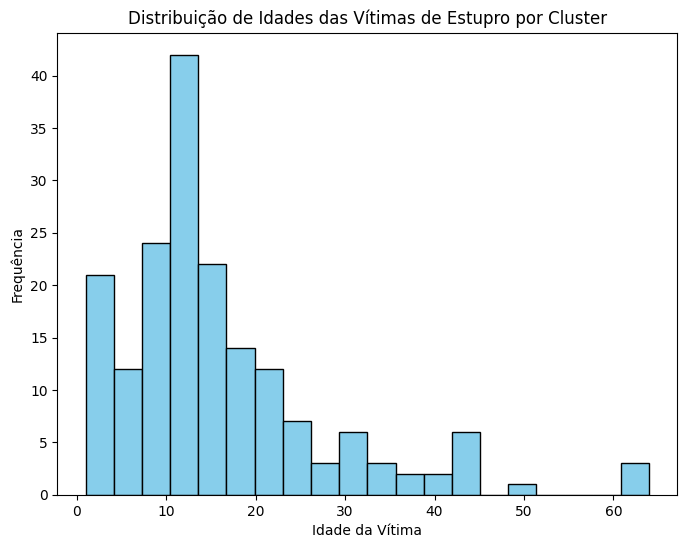

In [146]:
# Visualização dos clusters de idade para Estupro
plt.figure(figsize=(8, 6))
plt.hist(df_idade_estupro['Idade Vítima'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribuição de Idades das Vítimas de Estupro por Cluster')
plt.xlabel('Idade da Vítima')
plt.ylabel('Frequência')
plt.show()

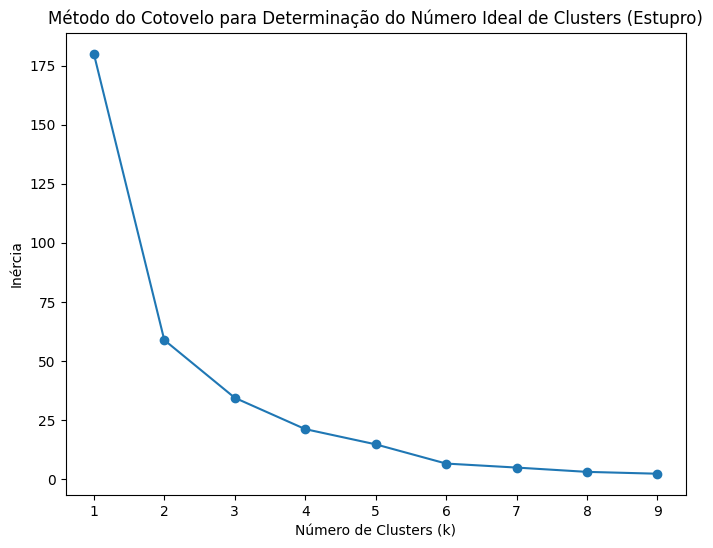

In [147]:
# Padronizar a coluna 'Idade Vítima' para clustering
idade_scaled_estupro = scaler.fit_transform(df_idade_estupro[['Idade Vítima']])

# Calcular a inércia para diferentes números de clusters
inertias_estupro = []
k_values = range(1, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(idade_scaled_estupro)
    inertias_estupro.append(kmeans.inertia_)

# Plotar o gráfico do método do cotovelo para Estupro
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertias_estupro, marker='o')
plt.title('Método do Cotovelo para Determinação do Número Ideal de Clusters (Estupro)')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.show()

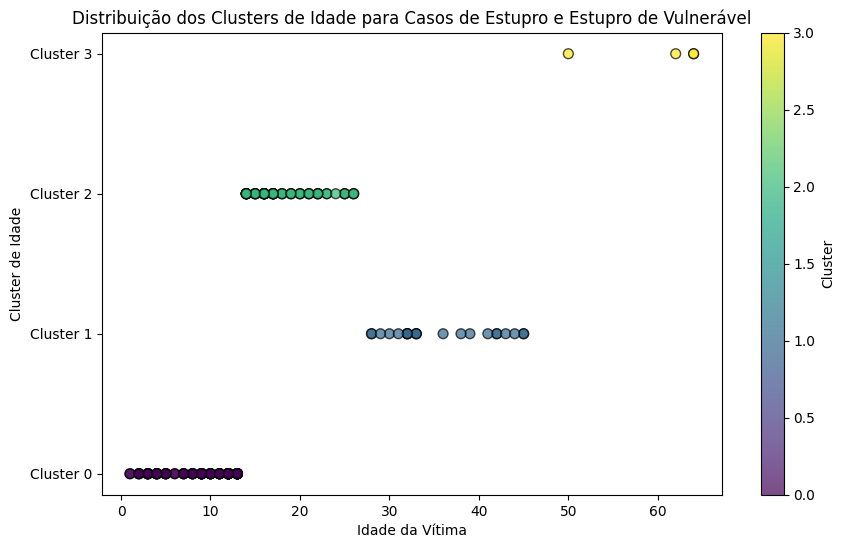

In [148]:
# Criar o gráfico de dispersão para a distribuição dos clusters de acordo com a idade
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_idade_estupro['Idade Vítima'], df_idade_estupro['Cluster'],
                      c=df_idade_estupro['Cluster'], cmap='viridis', s=50, alpha=0.7, edgecolor='k')
plt.colorbar(scatter, label='Cluster')
plt.title('Distribuição dos Clusters de Idade para Casos de Estupro e Estupro de Vulnerável')
plt.xlabel('Idade da Vítima')
plt.ylabel('Cluster de Idade')
plt.yticks(ticks=range(df_idade_estupro['Cluster'].nunique()), labels=[f'Cluster {i}' for i in range(df_idade_estupro['Cluster'].nunique())])

plt.show()